### Time to get your hands dirty! Planning a telescope observation


Let's build your first Markov Chain! 

You are a real astronomer (not a theory guy like me) and are planning an expensive observational campaign. You want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are, indeed, a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

![image.png](https://miro.medium.com/max/416/1*frksGjINf5oTjx7WL81U3w.png)

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the cumulative fraction of, say, sunny days over the number of days so far on the y axis. This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$.
- Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [30]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import random

plt.rc('text', usetex=True)  
plt.rc('font', family='serif')

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [66]:
def fraction_plot(x, variable='sunny days'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))  
    
    axs[0].plot(range(len(x)), x, color='purple')
    axs[0].set_title(f'Fraction of {variable} vs number of total days')
    axs[0].set_xlabel('Days', fontsize=14)
    axs[0].set_ylabel(f'Fraction of {variable}')
    axs[0].set_ylim(0., 1.05)
    axs[0].grid(True)
    axs[0].tick_params(axis='both')
    
    axs[1].hist(x, bins="scott", histtype="step", density=True, color='pink', linewidth=2)
    axs[1].set_title(f'Histogram of the fraction of {variable}')
    axs[1].set_xlabel(f'Fraction of {variable}', fontsize=14)
    axs[1].grid(True)
    axs[1].tick_params(axis='both')
    
    median_value = np.median(x)
    percentile_25 = np.percentile(x, 25)
    percentile_75 = np.percentile(x, 75)
    
    axs[1].axvline(median_value, color='darkblue', linestyle='--', label=f'Median = {median_value:.3f}')
    axs[1].axvline(percentile_25, color='lightblue', linestyle='--', label=f'25th percentile = {percentile_25:.3f}')
    axs[1].axvline(percentile_75, color='lightblue', linestyle='--', label=f'75th percentile = {percentile_75:.3f}')
    
    axs[1].legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [12]:
# 1 is sunny , 0 is cloudy 
random.seed(9)
today = 1

N = 50000

days = []

for n in range(N):
    days.append(today)
    if today == 0 :
        tomorrow = random.choices([0, 1], weights=[50, 50], k=1)[0]
    else :
          tomorrow = random.choices([0, 1], weights=[10, 90], k=1)[0]
    today = tomorrow
    
n_sun = [float(sum(days[:(x+1)])/(x+1)) for x in range(len(days))]

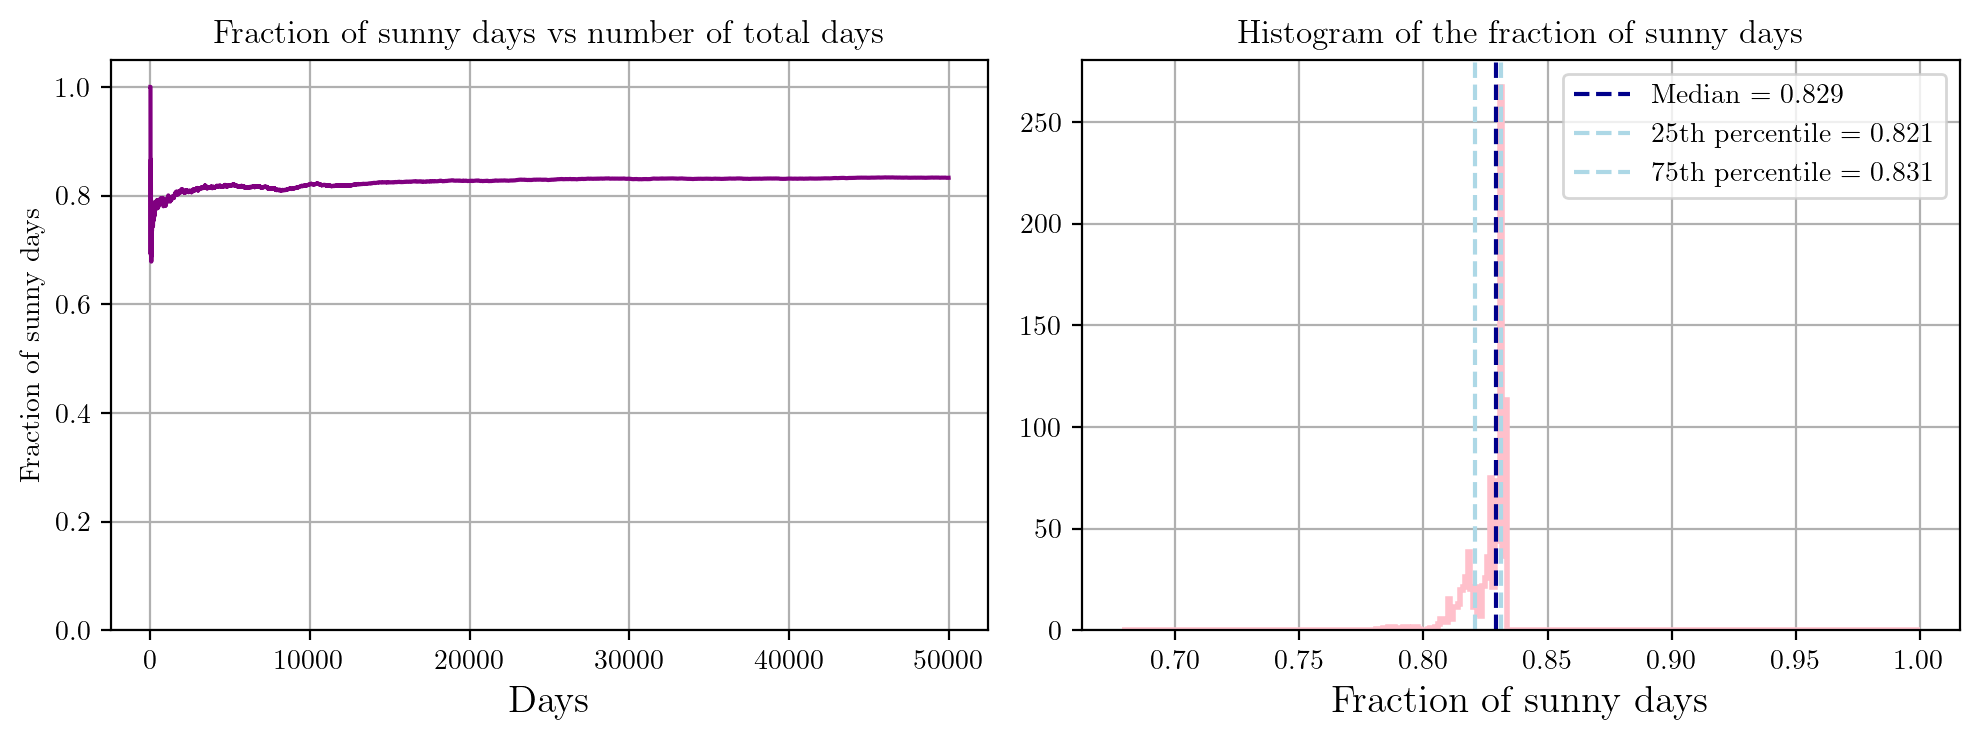

In [67]:
fraction_plot(n_sun)

#### I want to see how much the choice of the burnt points affects the mean and the median

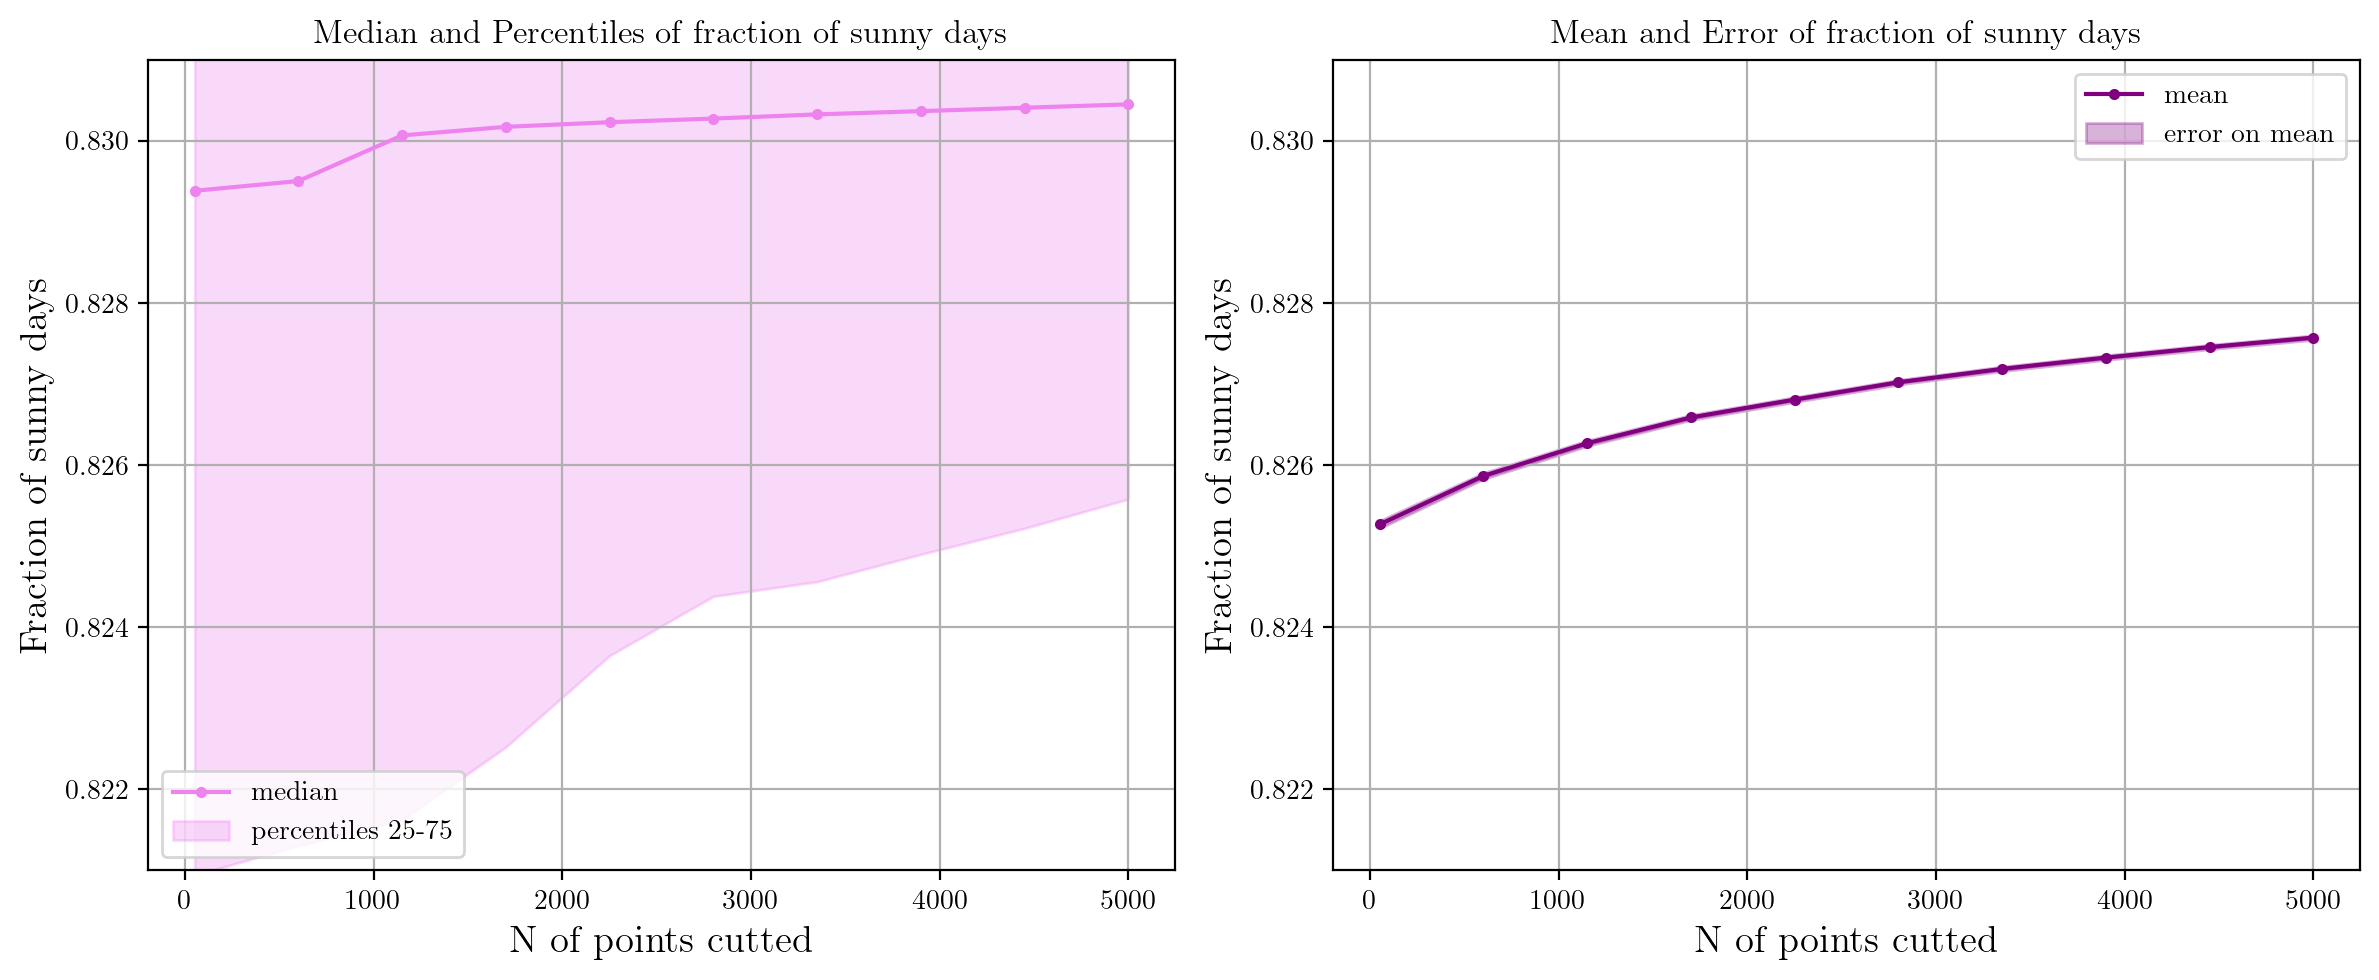

In [83]:
cuts = np.linspace(50, 5000, 10)
median = []
mean = []
perc_25 = []
perc_75 = []
s_mean = []

for c in cuts:
    cut_n_sun = np.copy(n_sun[int(c):])  
    median.append(np.median(cut_n_sun))
    mean.append(np.mean(cut_n_sun))
    perc_25.append(np.percentile(cut_n_sun, 25))
    perc_75.append(np.percentile(cut_n_sun, 75))
    s_mean.append(np.std(cut_n_sun)/np.sqrt(len(cut_n_sun)))

s_down = np.array(mean)-np.array(s_mean)
s_up = np.array(mean)+np.array(s_mean)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(cuts, median, marker='.', label='median', color='violet')
axs[0].fill_between(cuts, perc_25, perc_75, label='percentiles 25-75', color='violet', alpha=0.3)
axs[0].set_ylim(0.821, 0.831) 
axs[0].set_title('Median and Percentiles of fraction of sunny days')
axs[0].set_xlabel('N of points cutted', fontsize=14)
axs[0].set_ylabel('Fraction of sunny days', fontsize=14)
axs[0].legend()
axs[0].grid()

axs[1].plot(cuts, mean, marker='.', label='mean', color='purple')
axs[1].fill_between(cuts, s_down, s_up, label='error on mean', color='purple', alpha=0.3)
axs[1].set_ylim(0.821, 0.831) 
axs[1].set_title('Mean and Error of fraction of sunny days')
axs[1].set_xlabel('N of points cutted', fontsize=14)
axs[1].set_ylabel('Fraction of sunny days', fontsize=14)
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()


The mean is much more affected and the variability is higher

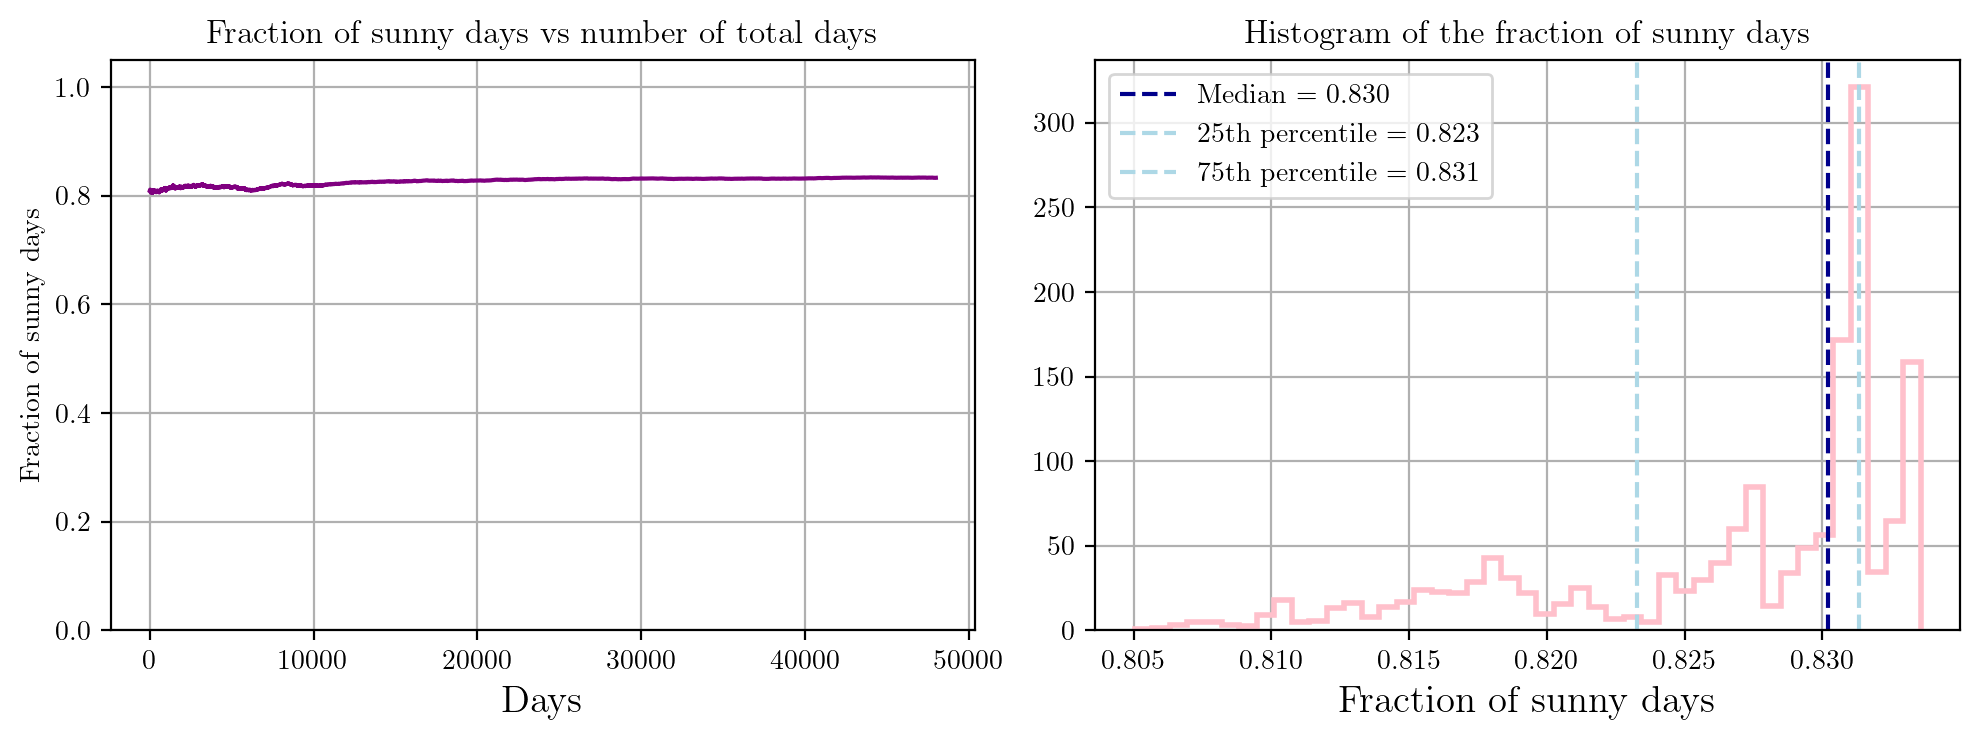

In [68]:
fraction_plot(n_sun[2000:])

#### More

- Redo the same for the Markovian process describing the stock market (see above in this notebook). If you've written your code well, this should require minor modifications.

In [52]:
#0 bull 1 bear 2 stagnant
#I am starting with bull
today = 0

N = 50000

days_market = []
n_bull = []
n_bear = []
n_stagnant = []

for n in range(N):
    days_market.append(today)
    if today == 0 :
        tomorrow = random.choices([0, 1, 2], weights=[90, 7.5, 2.5], k=1)[0]
    elif today == 1:
        tomorrow = random.choices([0, 1, 2], weights=[15, 80, 5], k=1)[0]
    else:
        tomorrow = random.choices([0, 1, 2], weights=[25, 25, 50], k=1)[0]
    today = tomorrow

    days_array = np.array(days_market)
    counts = np.bincount(days_array, minlength=3)
    n_bull.append(counts[0] / len(days_market))
    n_bear.append(counts[1] / len(days_market))
    n_stagnant.append(counts[2] / len(days_market))


# Calcola la frazione degli stati

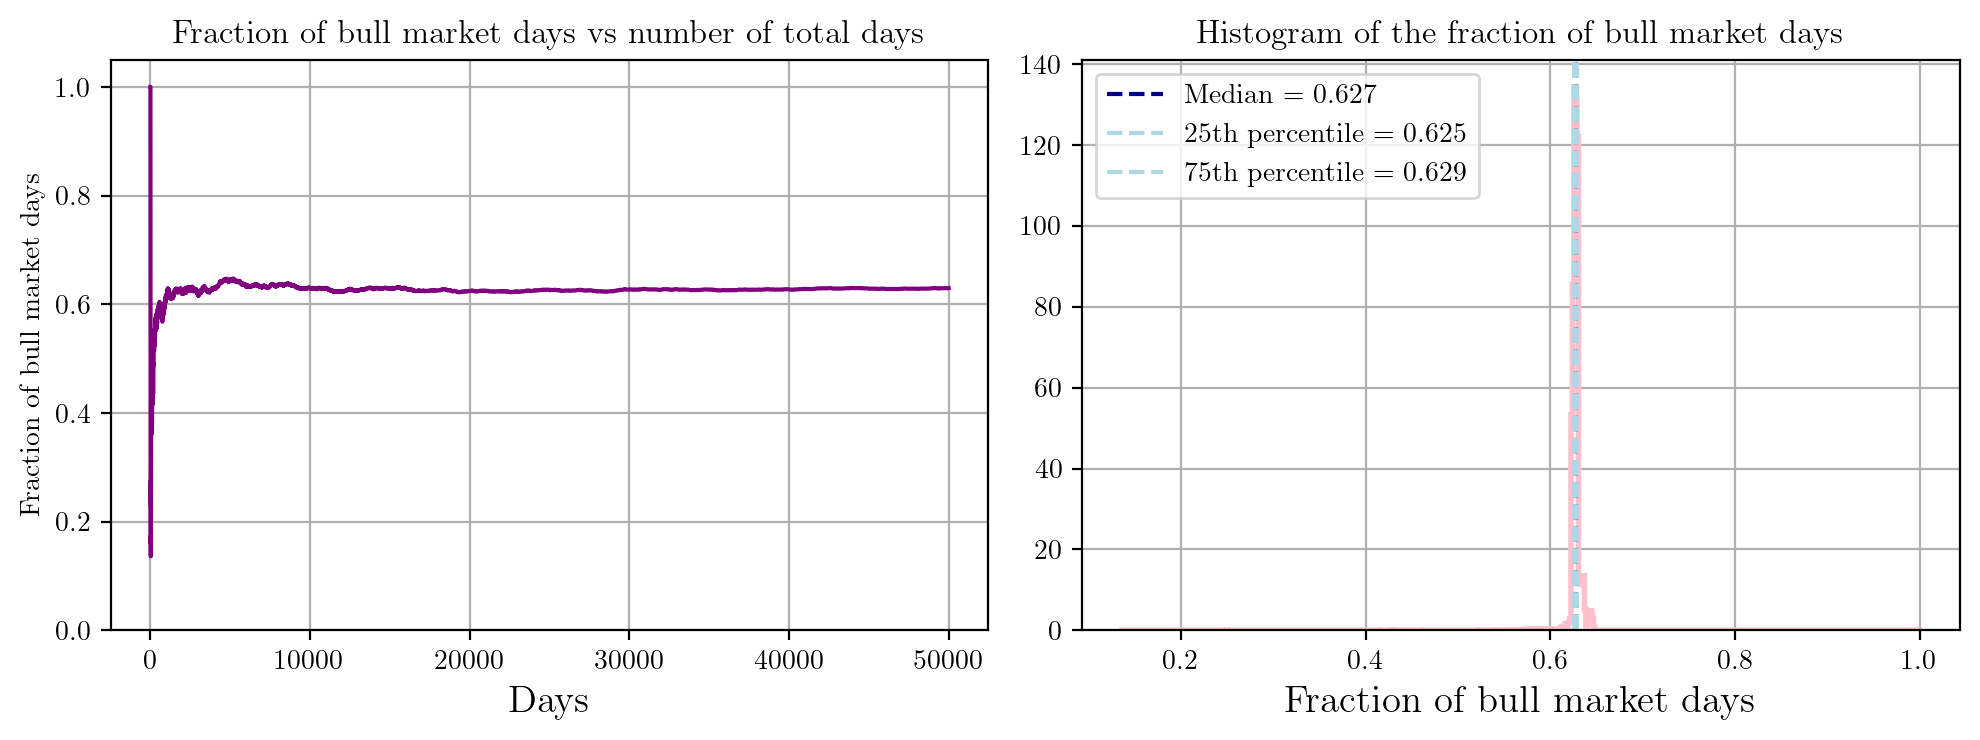

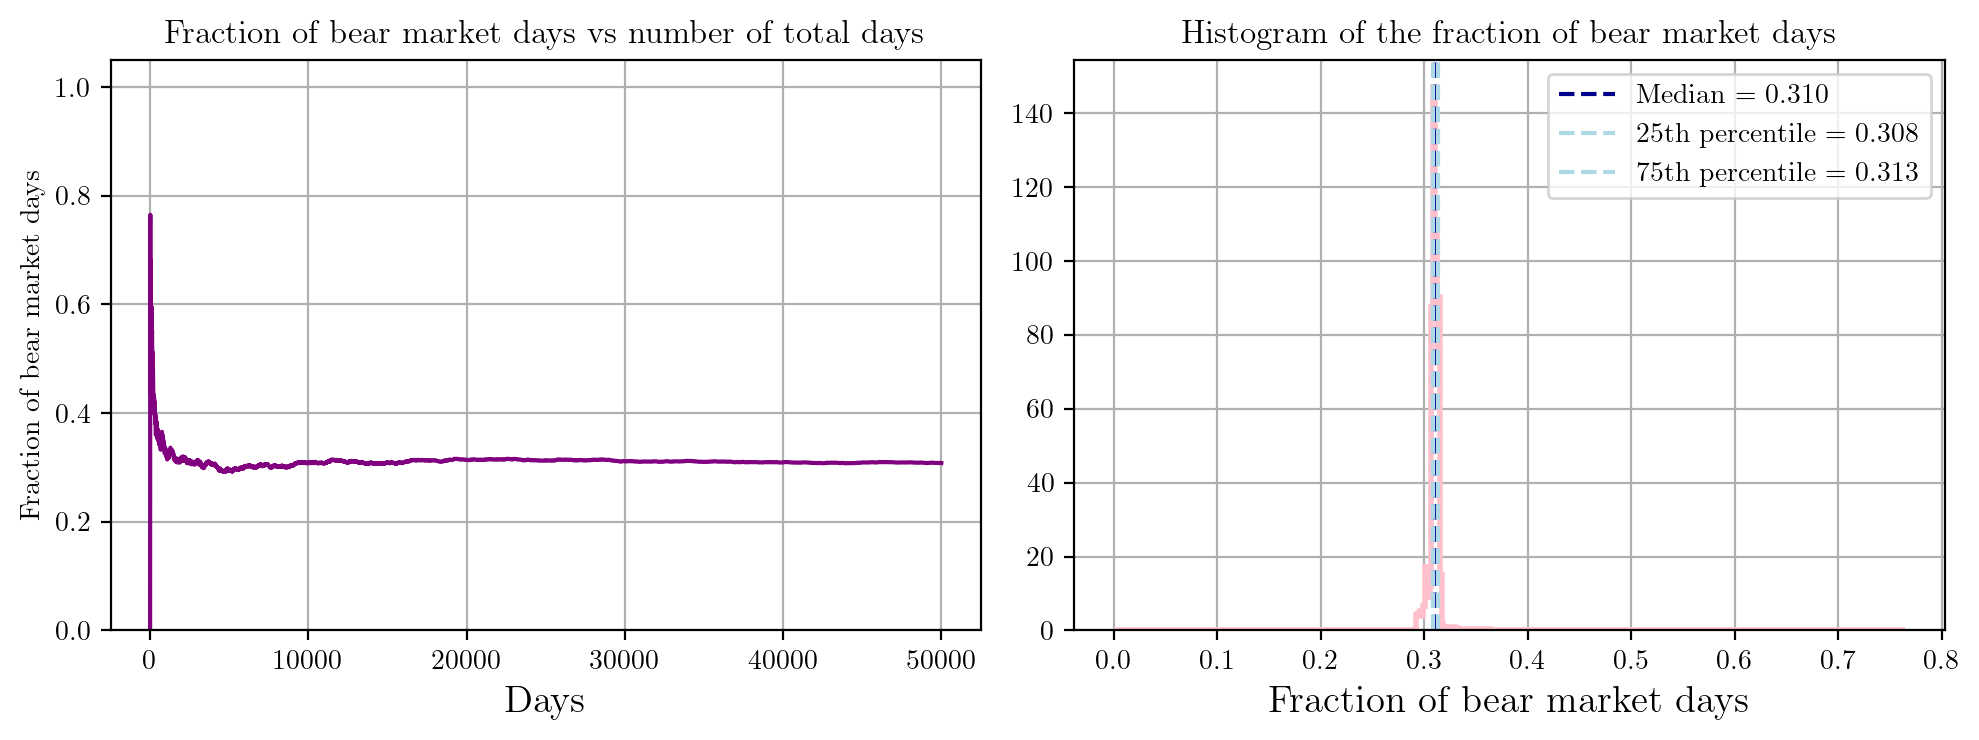

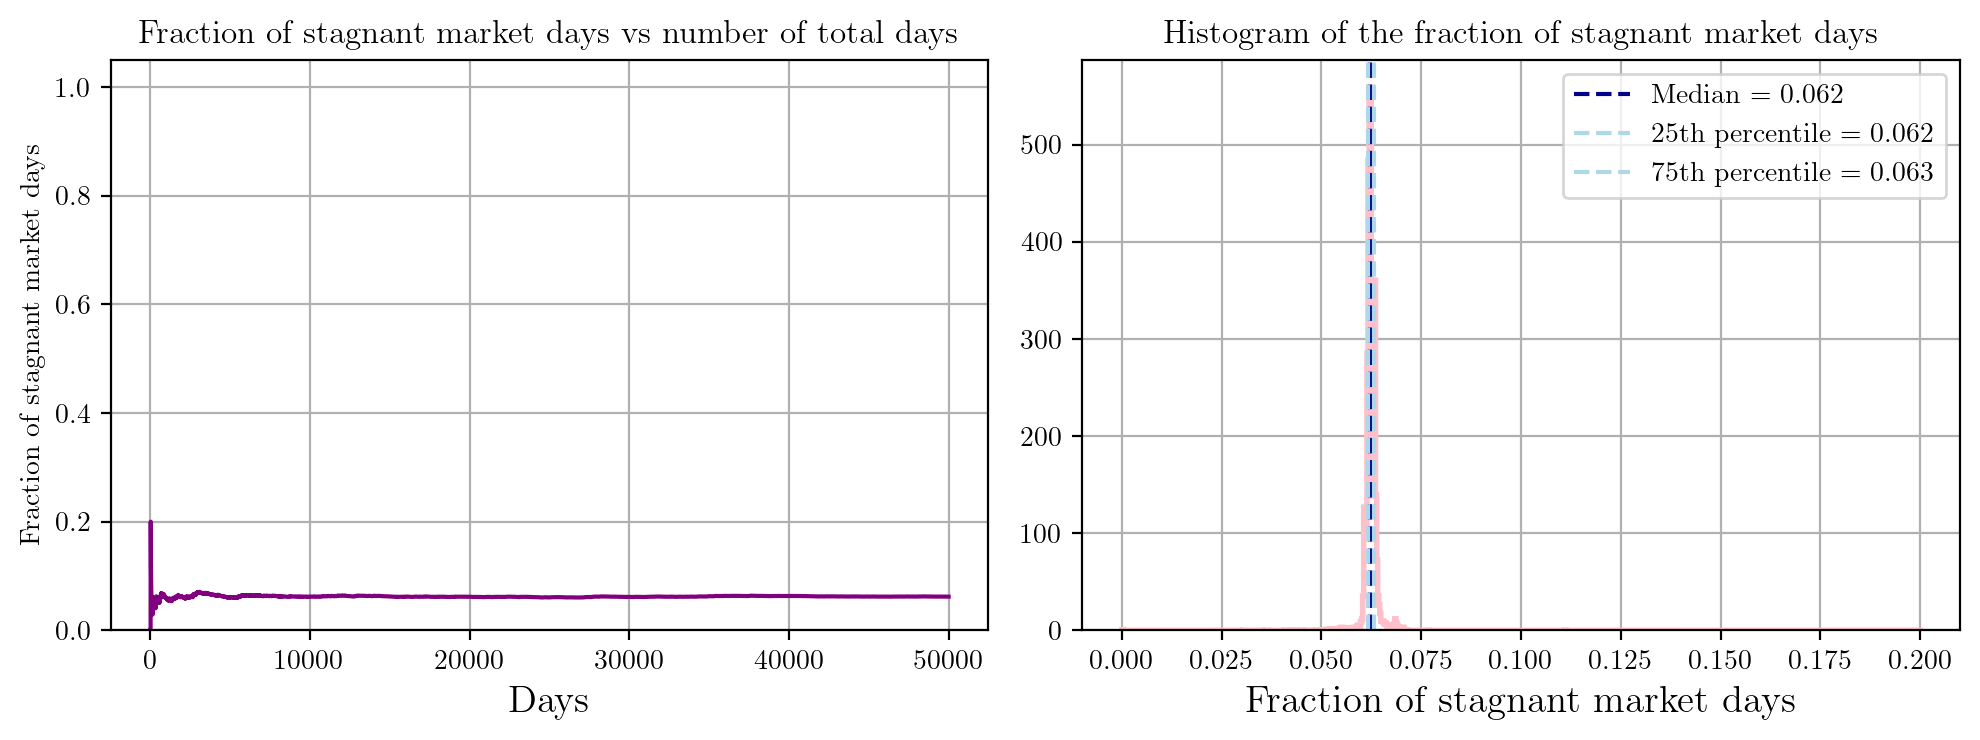

In [69]:
fraction_plot(n_bull, variable='bull market days')
fraction_plot(n_bear, variable='bear market days')
fraction_plot(n_stagnant, variable='stagnant market days')



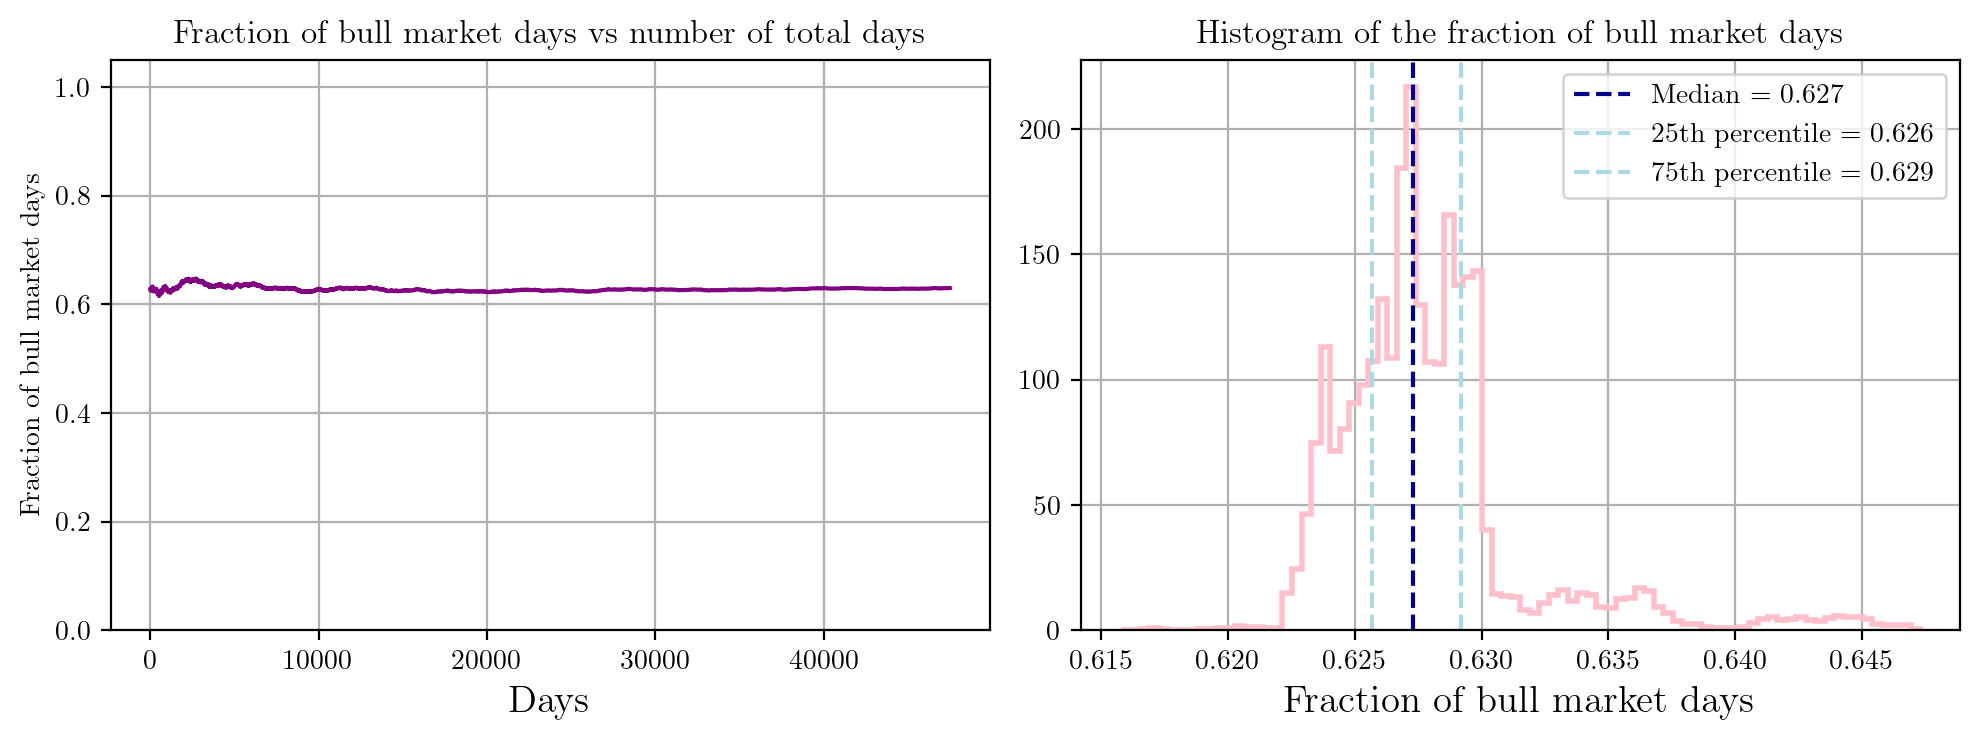

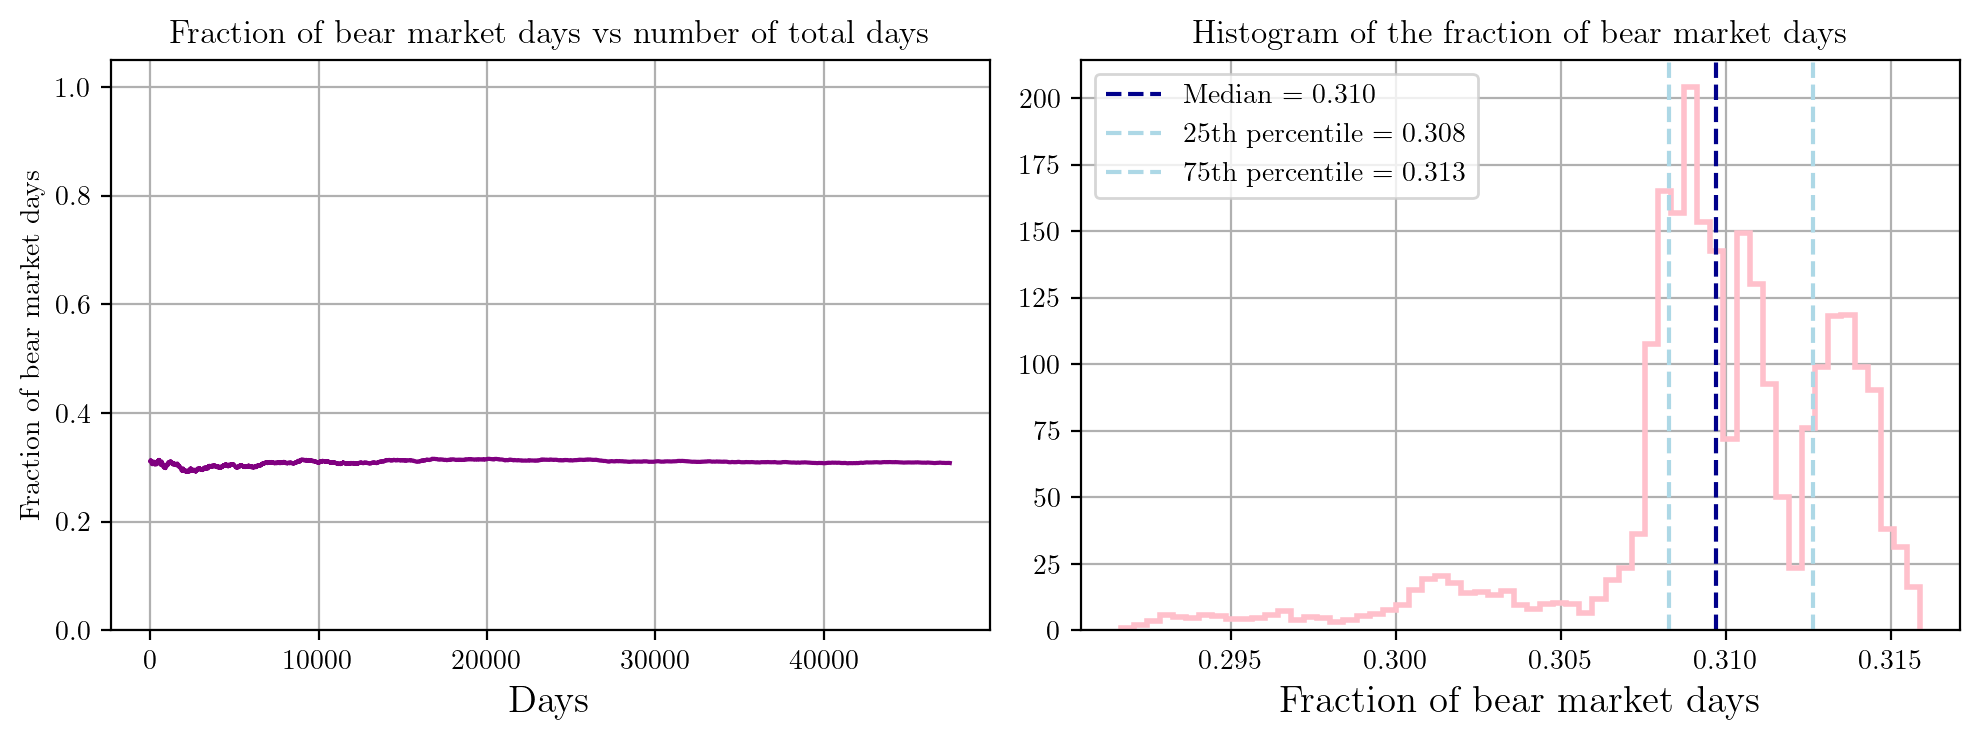

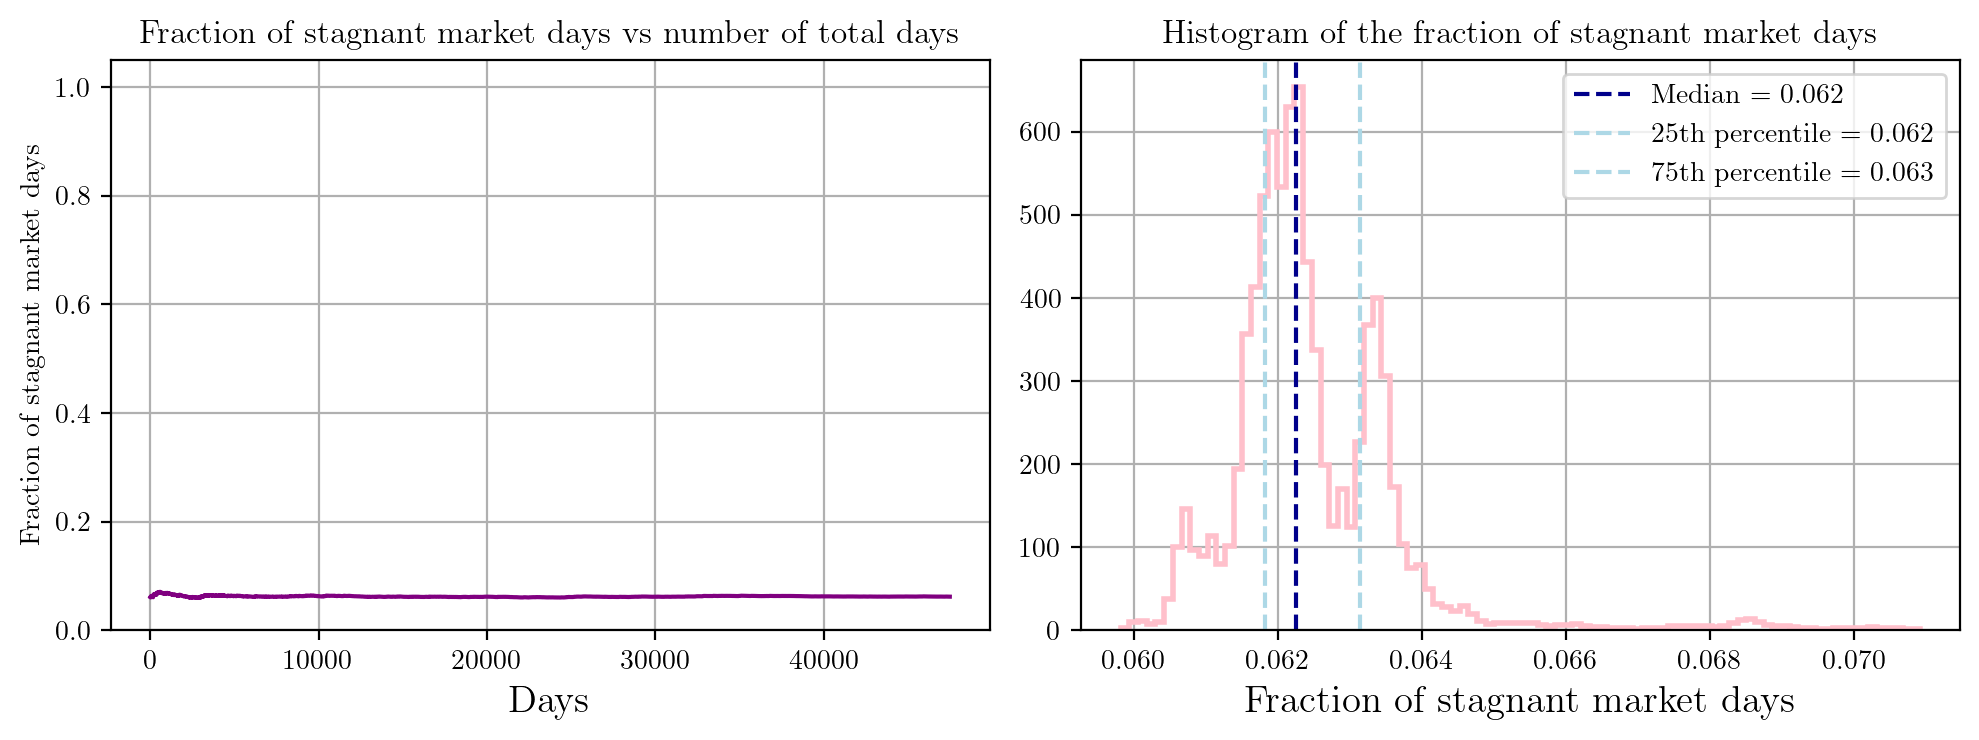

In [70]:
#cut at 2500

fraction_plot(n_bull[2500:], variable='bull market days')
fraction_plot(n_bear[2500:], variable='bear market days')
fraction_plot(n_stagnant[2500:], variable='stagnant market days')

